In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
# Load data
train_series = pd.read_parquet('./sleep_institute_data/train_series.parquet')
train_events = pd.read_csv('./sleep_institute_data/train_events.csv')

## Create labels for each step

In [3]:
def create_labels(series, events):
    """
    Generates step-wise labels for each time step in each series
    """
    unique_series = events.series_id.unique()
    
    all_labels = []
    for id in tqdm(unique_series):
        current_series = series[series.series_id.isin([id])]
        current_events = events[events.series_id.isin([id])]
        series_labels = np.zeros((current_series.shape[0],))
        prev_step = 0
        for i in range(current_events.shape[0]):
            if current_events.event.iloc[i] == 'onset':
                if not np.isnan(current_events.step.iloc[i]):
                    series_labels[prev_step:int(current_events.step.iloc[i])] = 0
                if np.isnan(current_events.step.iloc[i]):
                    try:
                        series_labels[prev_step:int(current_events.step.iloc[i+2])] = int(2)
                    except:
                        series_labels[prev_step:] = int(2)
            if current_events.event.iloc[i] == 'wakeup':
                if not np.isnan(current_events.step.iloc[i]):
                    series_labels[prev_step:int(current_events.step.iloc[i])] = int(1)
                if np.isnan(current_events.step.iloc[i]):
                    try:
                        series_labels[prev_step:int(current_events.step.iloc[i+1])] = int(2)
                    except:
                        series_labels[prev_step:] = int(2)
            if not np.isnan(current_events.step.iloc[i]):
                prev_step = int(current_events.step.iloc[i])

        # Correct for periods where watch isn't worn
        anglez_max = current_series.anglez.abs().rolling(window=500, center=True, min_periods=1).max().to_numpy()
        enmo_max = current_series.enmo.abs().rolling(window=500, center=True, min_periods=1).max().to_numpy()
        indxs = np.where((anglez_max < 75) & (enmo_max < 0.5) & (series_labels == 0))
        series_labels[indxs] = int(2)

        # Replace periods of unworn watches < 3 hours with label 0
        unworn_indxs = np.where(series_labels == 2)[0]
        unworn_windows = np.split(unworn_indxs, np.where(np.diff(unworn_indxs, prepend=unworn_indxs[0]-1) != 1)[0])
        unworn_duration = [array.shape[0] for array in unworn_windows]
        half_hour_length = 360*6  # Number of steps for 3 hours assuming 5 seconds per step
        ignore_indxs = [i for i in range(len(unworn_duration)) if unworn_duration[i] < half_hour_length]
        invalid_unworn_windows = [unworn_windows[ignore_indxs[i]] for i in range(len(ignore_indxs))]
        for window in invalid_unworn_windows:
            series_labels[window] = 0

        # Correct for ends where watch isn't worn with periods of wakefulness
        indxs = np.where((anglez_max > 75) & (series_labels == 2))
        series_labels[indxs] = int(0)

        all_labels.append(series_labels)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_labels
labels = create_labels(train_series, train_events)

# Add label column to series data
train_series['event'] = labels
train_series.head()

100%|██████████| 277/277 [07:07<00:00,  1.54s/it]


,series_id,step,timestamp,anglez,enmo,event
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217,0.0
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215,0.0
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216,0.0
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213,0.0
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215,0.0


## Chunk series into 24 hour segments

In [4]:
def chunk_series(train_series, train_events, ids):
   """
   Segments each series_id into 24 hour segments or less depending on when recording stops and ends. 
   Returns a list of numpy arrays of the anglez and enmo data and associated sleep state labels for 
   each step. Converts lists of data into 2D arrays (day in series, step) and saves to respective files.
   """
   day_length = 86400//5 # number of steps per 24 hours

   ambiguous_series = [4, 18, 15, 18, 55, 65, 68, 97, 103, 104, 116, 170, 249, 151, 262, 265, 271, 273]
   series_num = 0
   for id in tqdm(ids):
      if series_num in ambiguous_series:
         print('Skipping ambiguous series...')
         series_num += 1
         continue
      current_series = train_series[train_series.series_id.isin([id])]
      current_events = train_events[train_events.series_id.isin([id])]
      num_days = current_series.shape[0]//day_length + 1

      series_anglez = current_series.anglez.to_numpy()
      series_enmo = current_series.enmo.to_numpy()
      series_labels = current_series.event.to_numpy()
      anglez_diff_median = current_series.anglez.diff().abs().rolling(window=60, center=True, min_periods=1).median().to_numpy()
      anglez_diff_median = anglez_diff_median/np.max(anglez_diff_median)
      # anglez_min = current_series.anglez.rolling(window=60, center=True, min_periods=1).min().to_numpy()
      # anglez_max = current_series.anglez.rolling(window=60, center=True, min_periods=1).max().to_numpy()
      # anglez_std = current_series.anglez.rolling(window=12, center=True, min_periods=1).std().to_numpy()
      # anglez_mean = current_series.anglez.rolling(window=12, center=True, min_periods=1).mean().to_numpy()
      # enmo_min = current_series.enmo.rolling(window=60, center=True, min_periods=1).min().to_numpy()
      # enmo_max = current_series.enmo.rolling(window=60, center=True, min_periods=1).max().to_numpy()
      # enmo_std = current_series.enmo.rolling(window=12, center=True, min_periods=1).std().to_numpy()
      # enmo_mean = current_series.enmo.rolling(window=12, center=True, min_periods=1).mean().to_numpy()

      steps = current_series.step

      series_num += 1
      day_num = 0
      for i in range(num_days):

         try:
            first_step = steps.iloc[day_length*i]
            onset_step = current_events.step.iloc[2*i] - first_step
            wakeup_step = current_events.step.iloc[2*i+1] - first_step
         except:
            onset_step = np.nan
            wakeup_step = np.nan

         crits = np.array([onset_step, wakeup_step])
         np.save('./sleep_institute_data/chunked_data/' + id + '_events_day_' + str(day_num) + '.npy', crits)

         if i < num_days-1:
            data = np.stack([series_anglez[day_length*i:day_length*(i+1)],
                             series_enmo[day_length*i:day_length*(i+1)],
                             anglez_diff_median[day_length*i:day_length*(i+1)],
                             series_labels[day_length*i:day_length*(i+1)]], axis=0)

         if i == num_days-1:
            # Pad ends of incomplete days
            pad_length = day_length - series_anglez[day_length*i:].shape[0]

            end_anglez = np.pad(series_anglez[day_length*i:], ((0, pad_length)), constant_values=(0, 0))
            end_enmo = np.pad(series_enmo[day_length*i:], ((0, pad_length)), constant_values=(0, 0))
            end_diff_median = np.pad(anglez_diff_median[day_length*i:], ((0, pad_length)), constant_values=(0, 0))
            # end_ang_min = np.pad(anglez_min[day_length*i:], ((0, pad_length)), constant_values=(0, 0))
            # end_ang_max = np.pad(anglez_max[day_length*i:], ((0, pad_length)), constant_values=(0, 0))
            # end_ang_std = np.pad(anglez_std[day_length*i:], ((0, pad_length)), constant_values=(0, 0))
            # end_ang_mean = np.pad(anglez_mean[day_length*i:], ((0, pad_length)), constant_values=(0, 0))
            # end_enmo_min = np.pad(enmo_min[day_length*i:], ((0, pad_length)), constant_values=(0, 0))
            # end_enmo_max = np.pad(enmo_max[day_length*i:], ((0, pad_length)), constant_values=(0, 0))
            # end_enmo_std = np.pad(enmo_std[day_length*i:], ((0, pad_length)), constant_values=(0, 0))
            # end_enmo_mean = np.pad(enmo_mean[day_length*i:], ((0, pad_length)), constant_values=(0, 0))
            end_labels = np.pad(series_labels[day_length*i:], ((0, pad_length)), constant_values=(0, 2))

            data = np.stack([end_anglez,
                             end_enmo,
                             end_diff_median,
                             end_labels], axis=0)

         np.save('./sleep_institute_data/chunked_data/' + id + '_day_' + str(day_num) + '.npy', data)
         day_num += 1

In [5]:
unique_series = train_events.series_id.unique()
chunk_series(train_series, train_events, unique_series)

  1%|▏         | 4/277 [00:07<08:02,  1.77s/it]

Skipping ambiguous series...


  5%|▌         | 15/277 [00:24<07:31,  1.72s/it]

Skipping ambiguous series...


  6%|▋         | 18/277 [00:28<06:09,  1.43s/it]

Skipping ambiguous series...


 20%|█▉        | 55/277 [01:29<06:14,  1.69s/it]

Skipping ambiguous series...


 23%|██▎       | 65/277 [01:45<05:48,  1.64s/it]

Skipping ambiguous series...


 25%|██▍       | 68/277 [01:48<04:50,  1.39s/it]

Skipping ambiguous series...


 35%|███▌      | 97/277 [02:36<05:00,  1.67s/it]

Skipping ambiguous series...


 37%|███▋      | 103/277 [02:44<04:34,  1.58s/it]

Skipping ambiguous series...
Skipping ambiguous series...


 42%|████▏     | 116/277 [03:04<04:41,  1.75s/it]

Skipping ambiguous series...


 55%|█████▍    | 151/277 [04:02<03:37,  1.73s/it]

Skipping ambiguous series...


 61%|██████▏   | 170/277 [04:32<03:02,  1.71s/it]

Skipping ambiguous series...


 90%|████████▉ | 249/277 [06:45<00:48,  1.72s/it]

Skipping ambiguous series...


 95%|█████████▍| 262/277 [07:06<00:25,  1.68s/it]

Skipping ambiguous series...


 96%|█████████▌| 265/277 [07:09<00:17,  1.43s/it]

Skipping ambiguous series...


 98%|█████████▊| 271/277 [07:18<00:09,  1.54s/it]

Skipping ambiguous series...


 99%|█████████▊| 273/277 [07:19<00:04,  1.22s/it]

Skipping ambiguous series...


100%|██████████| 277/277 [07:25<00:00,  1.61s/it]


## Confirm alignment of labels

In [ ]:
def plot_series(train_events, train_series, index):
    series_choice = train_events.series_id.unique()[index]
    series_df = train_series[train_series.series_id.isin([series_choice])]
    series_step = series_df.step.to_numpy()
    series_anglez = series_df.anglez.to_numpy()
    series_enmo = series_df.enmo.to_numpy()
    series_labels = series_df.event.to_numpy()
    anglez_max = series_df.anglez.abs().rolling(window=500, center=True, min_periods=1).max()
    enmo_max = series_df.enmo.abs().rolling(window=500, center=True, min_periods=1).max()


    steps = np.arange(series_df.shape[0])

    event_df = train_events[train_events['series_id'] == series_choice]
    onset_steps = np.array(event_df[event_df['event'] == 'onset'].step)
    wakeup_steps = np.array(event_df[event_df['event'] == 'wakeup'].step)


    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, squeeze=True, figsize=(16, 8))

    ax1.plot(steps, series_anglez)

    ax1.vlines(onset_steps, -100, 100, colors='r', label='onset')
    ax1.vlines(wakeup_steps, -100, 100, colors='b', label='wakeup')

    ax1.fill_between(steps, y1=100, y2=-100, where=series_labels == 0, facecolor='lime', alpha=.5)
    ax1.fill_between(steps, y1=100, y2=-100, where=series_labels == 1, facecolor='orangered', alpha=.5)
    ax1.fill_between(steps, y1=100, y2=-100, where=series_labels == 2, facecolor='blue', alpha=.5)
    # ax1.set_ylabel('anglez freq')

    ax2.plot(steps, series_enmo)

    ax2.vlines(onset_steps, 0, 3, colors='r')
    ax2.vlines(wakeup_steps, 0, 3, colors='b')

    ax2.fill_between(steps, y1=4, y2=0, where=series_labels == 0, facecolor='lime', alpha=.5)
    ax2.fill_between(steps, y1=4, y2=0, where=series_labels == 1, facecolor='orangered', alpha=.5)
    ax2.fill_between(steps, y1=4, y2=0, where=series_labels == 2, facecolor='blue', alpha=.5)
    # ax2.fill_between(steps, y1=4, y2=0, where=(enmo_max < 0.5) & (series_labels != 1) & (series_labels != 2), 
    #                  facecolor='orange', alpha=.5)
    # ax2.set_xlabel('step')
    # ax2.set_ylabel('enmo')

    ax3.plot(steps, anglez_max)

    ax3.vlines(onset_steps, 0, 100, colors='r', label='onset')
    ax3.vlines(wakeup_steps, 0, 100, colors='b', label='wakeup')

    ax3.fill_between(steps, y1=100, y2=0, where=series_labels == 0, facecolor='lime', alpha=.5)
    ax3.fill_between(steps, y1=100, y2=0, where=series_labels == 1, facecolor='orangered', alpha=.5)
    ax3.fill_between(steps, y1=100, y2=0, where=series_labels == 2, facecolor='blue', alpha=.5)

    ax4.plot(steps, enmo_max)

    ax4.vlines(onset_steps, 0, 4, colors='r', label='onset')
    ax4.vlines(wakeup_steps, 0, 4, colors='b', label='wakeup')

    ax4.fill_between(steps, y1=4, y2=0, where=series_labels == 0, facecolor='lime', alpha=.5)
    ax4.fill_between(steps, y1=4, y2=0, where=series_labels == 1, facecolor='orangered', alpha=.5)
    ax4.fill_between(steps, y1=4, y2=0, where=series_labels == 2, facecolor='blue', alpha=.5)
    # ax4.fill_between(steps, y1=4, y2=0, where=(enmo_max < 0.5) & (anglez_max >= 75)
    #                  & (series_labels != 1), 
                    #  facecolor='orange', alpha=.5)

    # day = 1
    # plt.xlim([17280*(day-1), 17280*(day+3)])

    plt.show()
    plt.close()

In [ ]:
index = 0

In [ ]:
plot_series(train_events, train_series, index)
index+=1

In [59]:
index = 0
def plot_gaussian_series(train_events, train_series, index):
    series_choice = train_events.series_id.unique()[index]
    series_df = train_series[train_series.series_id.isin([series_choice])]
    steps = series_df.step.to_numpy()
    series_anglez = series_df.anglez.to_numpy()
    series_enmo = series_df.enmo.to_numpy()
    # series_onset_labels = series_df.onset.to_numpy()
    # series_wakeup_labels = series_df.wakeup.to_numpy()
    anglez_max = series_df.anglez.abs().rolling(window=60, center=True, min_periods=1).max()
    enmo_max = series_df.enmo.abs().rolling(window=10, center=True, min_periods=1).median()

    print(steps)

    event_df = train_events[train_events['series_id'] == series_choice]
    onset_steps = np.array(event_df[event_df['event'] == 'onset'].step)
    wakeup_steps = np.array(event_df[event_df['event'] == 'wakeup'].step)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, squeeze=True, figsize=(16, 8))

    ax1.plot(steps, series_anglez)
    # ax1.plot(steps, series_onset_labels*100, c='lime')
    # ax1.plot(steps, series_wakeup_labels*100, c='orangered')

    ax1.vlines(onset_steps, -100, 100, colors='r', label='onset')
    ax1.vlines(wakeup_steps, -100, 100, colors='b', label='wakeup')

    ax2.plot(steps, series_enmo)
    # ax2.plot(steps, series_onset_labels*4, c='lime')
    # ax2.plot(steps, series_wakeup_labels*4, c='orangered')

    ax2.vlines(onset_steps, 0, 3, colors='r')
    ax2.vlines(wakeup_steps, 0, 3, colors='b')
    # ax2.set_xlabel('step')
    # ax2.set_ylabel('enmo')

    ax3.plot(steps, anglez_max)
    # ax3.plot(steps, series_onset_labels*1, c='lime')
    # ax3.plot(steps, series_wakeup_labels*1, c='orangered')

    ax3.vlines(onset_steps, 0, 100, colors='r', label='onset')
    ax3.vlines(wakeup_steps, 0, 100, colors='b', label='wakeup')

    ax4.plot(steps, enmo_max)
    # ax4.plot(steps, series_onset_labels*0.01, c='lime')
    # ax4.plot(steps, series_wakeup_labels*0.01, c='orangered')

    ax4.vlines(onset_steps, 0, 2, colors='r', label='onset')
    ax4.vlines(wakeup_steps, 0, 2, colors='b', label='wakeup')

    # day = 1
    # plt.xlim([17280*(day-1), 17280*(day+3)])

    plt.show()
    plt.close()

[     0      1      2 ... 389877 389878 389879]


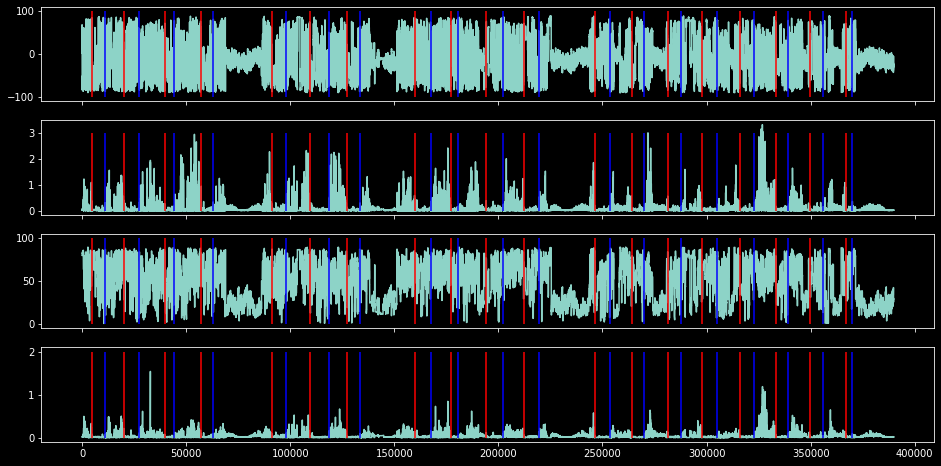

In [60]:
plot_gaussian_series(train_events, train_series, index)
index+=1